## Building makemore Part 2: MLP
#### https://www.youtube.com/watch?v=TCH_1BHY58I

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
words = open("data/names.txt", "r").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set("".join(words))))
stoi = {s:i for i,s in enumerate(chars,1)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# Creating training dataset
block_size = 3
X, y = [], []

random.seed(42)
random.shuffle(words)

for name in words:
    window = [0] * block_size
    for n in name + ".":
        n = stoi[n]
        X.append(window)
        y.append(n)
        window = window[1:] + [n]

X = torch.tensor(X)
y = torch.tensor(y)

In [6]:
# Dataset of 228146 examples with three words being fed into the neural network to predict the next single letter
print(X.shape)
print(y.shape)

torch.Size([228146, 3])
torch.Size([228146])


In [7]:
t = int(0.8*len(X))
d = int(0.9*len(X))
X_train, y_train = X[:t], y[:t]
X_val, y_val = X[t:d], y[t:d]
X_test, y_test = X[d:], y[d:]

In [8]:
print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print(len(X_test), len(y_test))

182516 182516
22815 22815
22815 22815


In [7]:
# Look up table containing embeddings for each letter (representing each word a two dimentional vector)
# C = torch.randn((27,2))

In [8]:
# Appling them in the dataset
# emb = C[X]
# print(emb.shape)
# Shape [examples, three_letter, two_dimentional_vector_to_represent_each_letter]

In [9]:
# According to Bengio paper, three word embeddings are concatenated and fed into the neural network
# Use .view() to manipulate the shape of a tensor **most efficient
# emb.view(-1,6).shape

In [17]:
# Defining the two layer neural network
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [36]:
# (1, 90) -> (90, 100) -> (100, 27)
# (1, 90) -> (1, 100)  -> (1, 27)  W

In [12]:
emb = C[X]
h = torch.tanh((emb.view(-1,6) @ W1) + b1)
logits = (h @ W2) + b2
# counts = logits.exp()
# probs = counts / counts.sum(1, keepdims=True)
# loss = -probs[torch.arange(X.shape[0]),y].log().mean()
loss = F.cross_entropy(logits, y)

In [13]:
loss

tensor(19.5052)

In [14]:
# It is more efficient to use F.cross_entropy because
# 1. Pytorch doesn't create intermediate tensor objects like counts, probs and the whole mathematical opration is done more efficiently 
# 2. Backward pass equation is also much simpler when we use F.cross_entropy
# 3. Pytorch makes sure the .exp() function doesn't return nan when the logits explode (by negating the array with max val)
# @33 min

In [18]:
for p in parameters:
    p.requires_grad = True

In [16]:
# Adding mini batch since it it much more efficient in practice
# Taking many steps with approx gradient direction is more efficient than calculating the exact gradient and taking fewer steps

In [17]:
# # Training loop
# for _ in range(10):

#     # Mini Batch
#     ix = torch.randint(0, X.shape[0], (32,)) # 32 is batch size
    
#     # Forward Pass
#     emb = C[X[ix]]
#     h = torch.tanh((emb.view(-1,6) @ W1) + b1)
#     logits = (h @ W2) + b2
#     loss = F.cross_entropy(logits, y[ix])
#     print(loss.item())

#     # Backward
#     for p in parameters:
#         p.grad = None
#     loss.backward()

#     # Update
#     for p in parameters:
#         p.data += -0.01 * p.grad

In [76]:
# x_ = 10 ** torch.linspace(-3, 0, 1000)
# y_ = torch.linspace(0, 1, 1000)
# plt.plot(x_, y_)

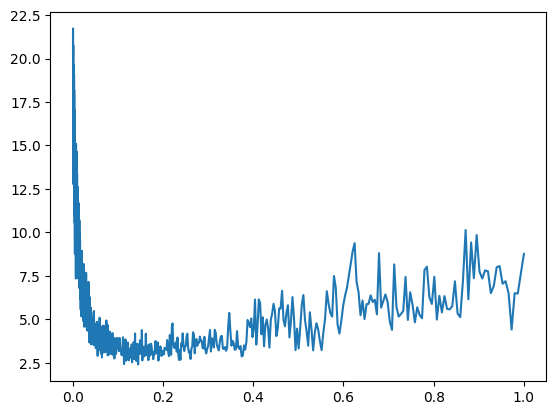

In [27]:
# Doubts on this method?? But a lr of 0.1 is noted to provide the least loss
plt.plot(lri, lossi)

In [37]:
# To determine an optimum learning rate we use x_ and also track loss
# lri = []
# lossi = []

for i in range(10000):

    # Mini Batch
    ix = torch.randint(0, X_train.shape[0], (64,)) # 32 is batch size
    
    # Forward Pass
    emb = C[X_train[ix]]
    h = torch.tanh((emb.view(-1,6) @ W1) + b1)
    logits = (h @ W2) + b2
    loss = F.cross_entropy(logits, y_train[ix])
    # print(loss.item())

    # Backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    # lr = x_[i]
    for p in parameters:
        p.data += -0.001 * p.grad

    # Tracking
    # lri.append(lr.item())
    # lossi.append(loss.item())

In [38]:
# Training loss
emb = C[X_train]
h = torch.tanh((emb.view(-1,6) @ W1) + b1)
logits = (h @ W2) + b2
loss = F.cross_entropy(logits, y_train)
print(loss.item())

2.2700693607330322


In [39]:
# Val loss
emb = C[X_val]
h = torch.tanh((emb.view(-1,6) @ W1) + b1)
logits = (h @ W2) + b2
loss = F.cross_entropy(logits, y_val)
print(loss.item())

2.2744553089141846


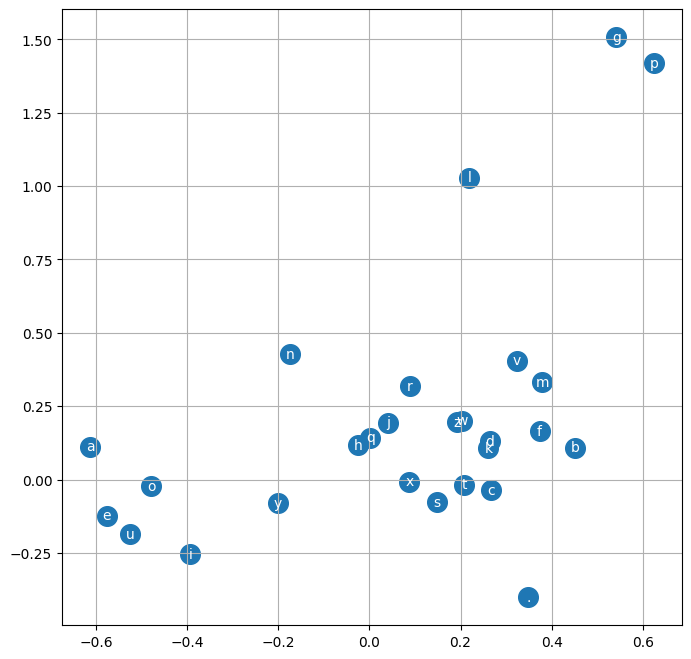

In [40]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [61]:
# For three dimensional embeddings
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,3), generator=g)
W1 = torch.randn((9,300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [62]:
for p in parameters:
    p.requires_grad = True

In [93]:
for _ in range(10000):

    ix = torch.randint(0, X_train.shape[0], (64,))
    
    # Forward pass
    emb = C[X_train[ix]]
    h = torch.tanh((emb.view(-1,9) @ W1) + b1)
    logits = (h @ W2) + b2
    loss = F.cross_entropy(logits, y_train[ix])
    
    # Backwards pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    for p in parameters:
        p.data += -0.0001 * p.grad

In [94]:
# Training loss
emb = C[X_train]
h = torch.tanh((emb.view(-1,9) @ W1) + b1)
logits = (h @ W2) + b2
loss = F.cross_entropy(logits, y_train)
print(loss.item())

2.2366952896118164


In [95]:
# Val loss
emb = C[X_val]
h = torch.tanh((emb.view(-1,9) @ W1) + b1)
logits = (h @ W2) + b2
loss = F.cross_entropy(logits, y_val)
print(loss.item())

2.248150110244751
